## Topic 2: LSTM 으로 “현대자동차” 일별 주식가격 예측하기

### 유튜브 영상 " https://youtu.be/BfpOUU-dN7I "

## [Task 2.1]

### 데이터 분석을 하기 위해 패키지 설치

In [1]:
# FinanceDataReader 패키지 설치 
#!pip install finance-datareader
import FinanceDataReader as fdr 
import numpy as np 
import matplotlib.pyplot as plt
import argparse
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from copy import deepcopy # Add Deepcopy for args
import datetime
import seaborn as sns
import os
import pandas as pd
import warnings
import tensorflow as tf

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import pandas as pd

In [4]:
from tensorflow import keras 

In [5]:
# 코스피 상장종목 전체 불러오기

df_kospi = fdr.StockListing('KOSPI')
df_kospi.head()

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,,59500,3,0,0.00,59500,59900,59100,7696187,457558919300,355202061725000,5969782550,STK
1,373220,KR7373220003,LG에너지솔루션,KOSPI,,482000,2,-3500,-0.72,482500,483000,473000,333848,159178309141,112788000000000,234000000,STK
2,207940,KR7207940008,삼성바이오로직스,KOSPI,,821000,2,-14000,-1.68,825000,831000,821000,21686,17848391000,58433854000000,71174000,STK
3,000660,KR7000660001,SK하이닉스,KOSPI,,79000,1,600,0.77,78300,80100,78300,1813544,143667793100,57512186835000,728002365,STK
4,051910,KR7051910008,LG화학,KOSPI,,633000,2,-12000,-1.86,640000,643000,627000,101519,64321516000,44684953119000,70592343,STK


In [6]:
# 코스피에 대한 정보 
df_kospi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Code         942 non-null    object 
 1   ISU_CD       942 non-null    object 
 2   Name         942 non-null    object 
 3   Market       942 non-null    object 
 4   Dept         942 non-null    object 
 5   Close        942 non-null    object 
 6   ChangeCode   942 non-null    object 
 7   Changes      942 non-null    int64  
 8   ChagesRatio  942 non-null    float64
 9   Open         942 non-null    int64  
 10  High         942 non-null    int64  
 11  Low          942 non-null    int64  
 12  Volume       942 non-null    int64  
 13  Amount       942 non-null    int64  
 14  Marcap       942 non-null    int64  
 15  Stocks       942 non-null    int64  
 16  MarketId     942 non-null    object 
dtypes: float64(1), int64(8), object(8)
memory usage: 125.2+ KB


## 현대차 데이터 불러오기 (005380)

In [7]:
# 현대차 데이터 불러오기 (005380)
#HD_stock = fdr.DataReader('005380', '2021-01-01', '2021-12-31')

start = (2021, 1, 1)
start = datetime.datetime(*start)
end = (2021, 12, 31)
end = datetime.datetime(*end)
HD_stock = fdr.DataReader('005380', start, end)
print(HD_stock)

              Open    High     Low   Close    Volume    Change
Date                                                          
2021-01-04  194000  211000  193500  207500   5651695  0.080729
2021-01-05  207000  213000  205000  209500   3022595  0.009639
2021-01-06  209500  211500  202500  203000   2848547 -0.031026
2021-01-07  206000  210500  204500  206000   2478337  0.014778
2021-01-08  240500  257000  225000  246000  19933702  0.194175
...            ...     ...     ...     ...       ...       ...
2021-12-24  210500  216500  210500  215500   1024355  0.031100
2021-12-27  216500  217000  213500  213500    530039 -0.009281
2021-12-28  215000  215000  211500  214000    880326  0.002342
2021-12-29  213000  215000  211500  212000    659392 -0.009346
2021-12-30  211500  212000  208500  209000    581448 -0.014151

[248 rows x 6 columns]


### DataFrame형식의 HD_stock 데이터

#### 위의 2021년 1월 1일부터 2021년 12월 31일까지의 데이터를 데이터 프레임의 형식으로 불러왔다. 
#### 248개의 row와 6개의 칼럼으로 구성되어 있는것을 확인할 수 있다.

In [8]:
print(type(HD_stock))

<class 'pandas.core.frame.DataFrame'>


In [9]:
# HD_stock 데이터 셋에서 null값이 있는지 확인
# null값이 있는날을 확인하고 없앨 수 있다.
HD_stock = HD_stock.dropna() 
HD_stock.info()   #확인 가능

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 2021-01-04 to 2021-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    248 non-null    int64  
 1   High    248 non-null    int64  
 2   Low     248 non-null    int64  
 3   Close   248 non-null    int64  
 4   Volume  248 non-null    int64  
 5   Change  248 non-null    float64
dtypes: float64(1), int64(5)
memory usage: 13.6 KB


In [10]:
# min-max실행전에 우선 원래 데이터를 HD_stock1로 보관함
HD_stock1 = HD_stock

In [11]:
HD_stock1.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-01-04,194000,211000,193500,207500,5651695,0.080729
2021-01-05,207000,213000,205000,209500,3022595,0.009639
2021-01-06,209500,211500,202500,203000,2848547,-0.031026
2021-01-07,206000,210500,204500,206000,2478337,0.014778
2021-01-08,240500,257000,225000,246000,19933702,0.194175


#### 데이터를 0 과 1 사이로 MinMax scaling 작업

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(HD_stock[scale_cols])
scaled

array([[0.0375    , 0.17021277, 0.06382979, 0.18918919, 0.27024741],
       [0.2       , 0.19148936, 0.22695035, 0.21621622, 0.13591107],
       [0.23125   , 0.17553191, 0.19148936, 0.12837838, 0.12701792],
       ...,
       [0.3       , 0.21276596, 0.31914894, 0.27702703, 0.02644981],
       [0.275     , 0.21276596, 0.31914894, 0.25      , 0.01516098],
       [0.25625   , 0.18085106, 0.27659574, 0.20945946, 0.01117836]])

In [13]:
HD_stock.describe()

,Open,High,Low,Close,Volume,Change
count,248.000000,248.000000,248.000000,248.000000,2.480000e+02,248.000000
mean,223770.161290,226645.161290,220729.838710,223381.048387,1.220738e+06,0.000588
std,15400.378458,16273.444526,14480.952056,15145.881835,1.743217e+06,0.022717
min,191000.000000,195000.000000,189000.000000,193500.000000,3.626760e+05,-0.062124
25%,210375.000000,212000.000000,208000.000000,209500.000000,6.071025e+05,-0.010923
50%,223750.000000,225000.000000,221250.000000,223500.000000,8.231965e+05,0.000000
75%,235125.000000,238000.000000,230875.000000,234250.000000,1.168822e+06,0.008457
max,271000.000000,289000.000000,259500.000000,267500.000000,1.993370e+07,0.194175


In [14]:
# 스케일링한 HD_stock을 scaled의 어래이 형식 확인
scaled

array([[0.0375    , 0.17021277, 0.06382979, 0.18918919, 0.27024741],
       [0.2       , 0.19148936, 0.22695035, 0.21621622, 0.13591107],
       [0.23125   , 0.17553191, 0.19148936, 0.12837838, 0.12701792],
       ...,
       [0.3       , 0.21276596, 0.31914894, 0.27702703, 0.02644981],
       [0.275     , 0.21276596, 0.31914894, 0.25      , 0.01516098],
       [0.25625   , 0.18085106, 0.27659574, 0.20945946, 0.01117836]])

####  array형식의 데이터를 DataFrame형식으로 변환

In [15]:
df = pd.DataFrame(scaled, columns=scale_cols)

In [16]:
df

,Open,High,Low,Close,Volume
0,0.03750,0.170213,0.063830,0.189189,0.270247
1,0.20000,0.191489,0.226950,0.216216,0.135911
2,0.23125,0.175532,0.191489,0.128378,0.127018
3,0.18750,0.164894,0.219858,0.168919,0.108102
4,0.61875,0.659574,0.510638,0.709459,1.000000
...,...,...,...,...,...
243,0.24375,0.228723,0.304965,0.297297,0.033809
244,0.31875,0.234043,0.347518,0.270270,0.008552
245,0.30000,0.212766,0.319149,0.277027,0.026450
246,0.27500,0.212766,0.319149,0.250000,0.015161


In [17]:
import tensorflow as tf

In [18]:
from sklearn.preprocessing import MinMaxScaler

df.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df_scaled = scaler.fit_transform(df[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled.describe()

,Open,High,Low,Close,Volume
count,248.000000,248.000000,248.000000,248.000000,248.000000
mean,0.409627,0.336651,0.450069,0.403798,0.043843
std,0.192505,0.173122,0.205404,0.204674,0.089071
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.242187,0.180851,0.269504,0.216216,0.012489
50%,0.409375,0.319149,0.457447,0.405405,0.023531
75%,0.551562,0.457447,0.593972,0.550676,0.041191
max,1.000000,1.000000,1.000000,1.000000,1.000000


## TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

### Hyperparameter를 정의

In [19]:
TEST_SIZE = 75
WINDOW_SIZE = 60

train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

#### dataset 만들기

In [20]:
def make_dataset(data, label, window_size=60):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

#### window_size는 얼마동안(기간)의 주가 데이터에 기반하여 
#### 다음날 종가를 예측할 것인지 정하는 parameter입니다.
#### 즉, 과거 60일을 기반으로 내일 데이터를 예측

In [21]:
from sklearn.model_selection import train_test_split

feature_cols = ['Open', 'High', 'Low', 'Volume']
label_cols = ['Close']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 20)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.3)
x_train.shape, x_valid.shape

((107, 20, 4), (46, 20, 4))

In [22]:
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

((75, 4), (75, 1))

In [23]:
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((55, 20, 4), (55, 1))

### 모형 학습

In [24]:
### 모형학습

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

In [25]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1344      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 1,361
Trainable params: 1,361
Non-trainable params: 0
_________________________________________________________________
None


#### 에폭 횟수(학습용 전체데이터를 몇 회 반복해서 학습할 것인가 입력)
#### earlystopping은 5번, epoch통안 val_loss 개선이 없다면 학습을 멈춤.
#### # val_loss 기준 체크포인터도 생성.

In [26]:
import os

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                                    epochs=50, 
                                    batch_size=16,
                                    validation_data=(x_valid, y_valid), 
                                    callbacks=[early_stop, checkpoint])

Epoch 1/50
5/7 [====================>.........] - ETA: 0s - loss: 0.2599 
Epoch 1: val_loss improved from inf to 0.17659, saving model to model\tmp_checkpoint.h5
7/7 [==============================] - 8s 264ms/step - loss: 0.2408 - val_loss: 0.1766
Epoch 2/50
5/7 [====================>.........] - ETA: 0s - loss: 0.1545
Epoch 2: val_loss improved from 0.17659 to 0.08695, saving model to model\tmp_checkpoint.h5
7/7 [==============================] - 0s 51ms/step - loss: 0.1404 - val_loss: 0.0870
Epoch 3/50
5/7 [====================>.........] - ETA: 0s - loss: 0.0633
Epoch 3: val_loss improved from 0.08695 to 0.02225, saving model to model\tmp_checkpoint.h5
7/7 [==============================] - 0s 51ms/step - loss: 0.0560 - val_loss: 0.0223
Epoch 4/50
5/7 [====================>.........] - ETA: 0s - loss: 0.0139
Epoch 4: val_loss improved from 0.02225 to 0.01205, saving model to model\tmp_checkpoint.h5
7/7 [==============================] - 0s 51ms/step - loss: 0.0136 - val_loss: 0.012

#### 저장한 ModelCheckpoint 를 로드.

In [27]:
model.load_weights(filename)
pred = model.predict(test_feature)

pred.shape

2/2 [==============================] - 1s 6ms/step


(55, 1)

#### test_feature를 활용하여 예측을 진행.

## 예측 데이터 시각화 
#### 0과 1사이의 값으로 스케일링했던 주가를 환원하지 않고 그래프를 그려보았다.

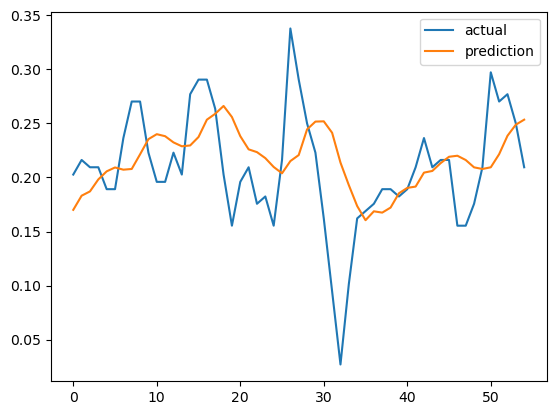

In [28]:
plt.figure()
plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()

In [29]:
pred

array([[0.1700626 ],
       [0.18314928],
       [0.18712005],
       [0.19821958],
       [0.2056724 ],
       [0.2092658 ],
       [0.20721656],
       [0.20787987],
       [0.22142303],
       [0.23546535],
       [0.24005762],
       [0.23819464],
       [0.23246488],
       [0.22887015],
       [0.22963601],
       [0.23745082],
       [0.25345552],
       [0.25892156],
       [0.26617095],
       [0.25594702],
       [0.23824385],
       [0.22603095],
       [0.22345342],
       [0.21791734],
       [0.20973018],
       [0.2038947 ],
       [0.21518414],
       [0.22074702],
       [0.24450669],
       [0.2517103 ],
       [0.25194442],
       [0.24135026],
       [0.21377751],
       [0.19292964],
       [0.17359275],
       [0.16047154],
       [0.16871378],
       [0.16750018],
       [0.17215581],
       [0.185394  ],
       [0.19037184],
       [0.19158626],
       [0.2044926 ],
       [0.20605284],
       [0.21329959],
       [0.21915686],
       [0.22012082],
       [0.216

In [30]:
df_scaled.describe()

,Open,High,Low,Close,Volume
count,248.000000,248.000000,248.000000,248.000000,248.000000
mean,0.409627,0.336651,0.450069,0.403798,0.043843
std,0.192505,0.173122,0.205404,0.204674,0.089071
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.242187,0.180851,0.269504,0.216216,0.012489
50%,0.409375,0.319149,0.457447,0.405405,0.023531
75%,0.551562,0.457447,0.593972,0.550676,0.041191
max,1.000000,1.000000,1.000000,1.000000,1.000000


#### array형식을 DataFrame형식으로 변환

In [31]:
data_pred = pd.DataFrame(pred)

In [32]:
data_actual = pd.DataFrame(test_label)

In [33]:
data_pred.head()

,0
0,0.170063
1,0.183149
2,0.187120
3,0.198220
4,0.205672


#### 0 과 1 사이의 값을 이제는 원래 주가로 환원

In [34]:
# 0 과 1 사이의 값을 원래 주가로 환원 
pred_close = (max(HD_stock1["Close"])-min(HD_stock1["Close"]))*data_pred + min(HD_stock1["Close"]) 
actual_close = (max(HD_stock1["Close"])-min(HD_stock1["Close"]))*data_actual + min(HD_stock1["Close"])

#### 환원이 잘 되었는지 확인

In [35]:
pred_close.head()

,0
0,206084.632516
1,207053.046584
2,207346.883714
3,208168.249100
4,208719.757468


In [36]:
actual_close.head()

,0
0,208500.0
1,209500.0
2,209000.0
3,209000.0
4,207500.0


### 환원된 주가의 실제값과 예측값 시각화

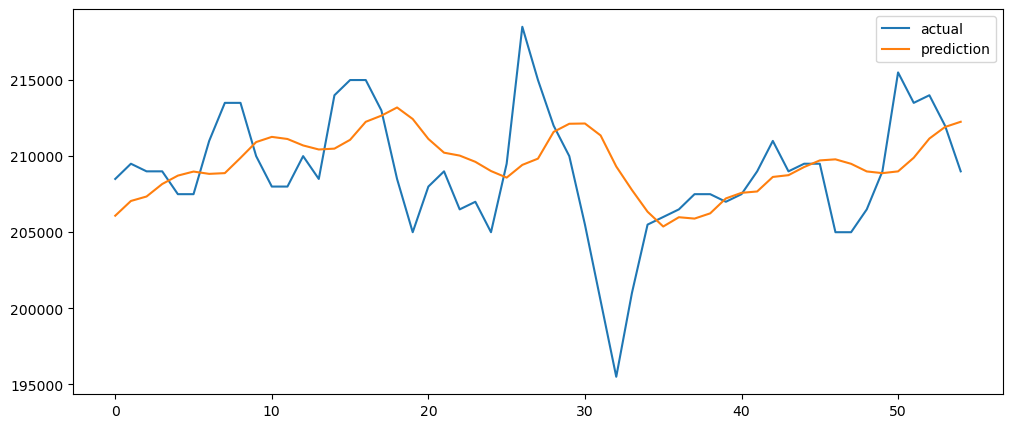

In [37]:
plt.figure(figsize=(12, 5))
plt.plot(actual_close, label = 'actual')
plt.plot(pred_close, label = 'prediction')
plt.legend()
plt.show()

# RNN

#### keras.layers.SimpleRNN으로 신경망을 설계
#### input_shape은 LSTM과 마찬가지로 
#### train_feature.shape[1]과 train_feature.shape[2]을 입력
#### 활성화 함수는 relu를 사용하고 
#### Dense 레이어는 1개로 구성

In [38]:
# RNN 을 이용하여 신경망 설계
RNN_model = keras.Sequential([
keras.layers.SimpleRNN(16, return_sequences = True, #return_sequence=True로 설정하면 레이어의 출력을 다음 레이어로 그대로 넘겨줌
input_shape=(train_feature.shape[1], train_feature.shape[2]), activation='relu'),

keras.layers.SimpleRNN(16, input_shape=(train_feature.shape[1], train_feature.shape[2]), activation='relu'),
keras.layers.Dense(1, activation=None),
])

#### 모델의 서머리를 통해서 좀 더 자세히 확인할 수 있었다. 
#### 총 Total 파라미터는 881

In [39]:
print(RNN_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20, 16)            336       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 881
Trainable params: 881
Non-trainable params: 0
_________________________________________________________________
None


In [1]:
# 코렙에서만 생성이 가능한 시각화 

# import tensorflow as tf
# import pydot
# !pip install pydot
# from keras.utils.vis_utils import plot_model
# tf.keras.utils.plot_model(model, "RNN.png", show_shapes=True)

NameError: name 'model' is not defined

#### loss 평션은 민스퀘어에러로 하고 옵티마이져는 아담을 사용

In [41]:
# RNN 모델 실행
RNN_model.compile(optimizer='adam', loss='mean_squared_error')
RNN_model.fit(x_train, y_train, epochs=30)

Epoch 1/30
4/4 [==============================] - 8s 16ms/step - loss: 0.1837
Epoch 2/30
4/4 [==============================] - 0s 18ms/step - loss: 0.1327
Epoch 3/30
4/4 [==============================] - 0s 18ms/step - loss: 0.0664
Epoch 4/30
4/4 [==============================] - 0s 18ms/step - loss: 0.0155
Epoch 5/30
4/4 [==============================] - 0s 18ms/step - loss: 0.0334
Epoch 6/30
4/4 [==============================] - 0s 18ms/step - loss: 0.0158
Epoch 7/30
4/4 [==============================] - 0s 18ms/step - loss: 0.0141
Epoch 8/30
4/4 [==============================] - 0s 17ms/step - loss: 0.0174
Epoch 9/30
4/4 [==============================] - 0s 17ms/step - loss: 0.0129
Epoch 10/30
4/4 [==============================] - 0s 17ms/step - loss: 0.0109
Epoch 11/30
4/4 [==============================] - 0s 17ms/step - loss: 0.0124
Epoch 12/30
4/4 [==============================] - 0s 16ms/step - loss: 0.0108
Epoch 13/30
4/4 [==============================] - 0s 17ms/st

In [42]:
# RNN 예측 수행
RNN_pred = RNN_model.predict(test_feature)
print('***예측값 보기***')
print(RNN_pred)

2/2 [==============================] - 1s 5ms/step
***예측값 보기***
[[0.20392346]
 [0.18464933]
 [0.22605065]
 [0.18441755]
 [0.24361378]
 [0.21113679]
 [0.2527227 ]
 [0.22943255]
 [0.24153647]
 [0.23484865]
 [0.2714496 ]
 [0.25471598]
 [0.27447608]
 [0.24799308]
 [0.25824368]
 [0.25987223]
 [0.2570299 ]
 [0.28563008]
 [0.26326957]
 [0.30734938]
 [0.27302545]
 [0.28691426]
 [0.26293766]
 [0.28188515]
 [0.26649976]
 [0.2675178 ]
 [0.24240091]
 [0.27884534]
 [0.2259184 ]
 [0.32648638]
 [0.24624574]
 [0.3304168 ]
 [0.2579985 ]
 [0.296922  ]
 [0.25751004]
 [0.26812655]
 [0.2286992 ]
 [0.26262856]
 [0.20347291]
 [0.22818615]
 [0.2248503 ]
 [0.21549897]
 [0.22412297]
 [0.22091529]
 [0.22123948]
 [0.23860627]
 [0.23486526]
 [0.24894099]
 [0.24730426]
 [0.23993927]
 [0.24365953]
 [0.23469433]
 [0.23710461]
 [0.26474324]
 [0.2547556 ]]


#### 스케일링 값을 환원하지 않고 그래프를 그려보기

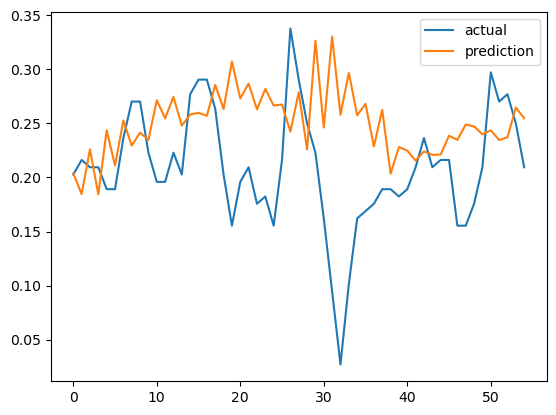

In [43]:
plt.figure()
plt.plot(test_label, label = 'actual')
plt.plot(RNN_pred, label = 'prediction')
plt.legend()
plt.show()

In [44]:
# 0 과 1 사이의 값을 원래 주가로 환원
data_RNN_pred = pd.DataFrame(RNN_pred)
data_RNN_real = pd.DataFrame(test_label)
pred_close_RNN = (max(HD_stock1["Close"])-min(HD_stock1["Close"]))*data_RNN_pred + min(HD_stock1["Close"]) 
actual_close_RNN = (max(HD_stock1["Close"])-min(HD_stock1["Close"]))*data_RNN_real + min(HD_stock1["Close"])

#### 0과 1사이의 값을 원래주가로 환원한 값으로 
#### 다시 그래프 그리기

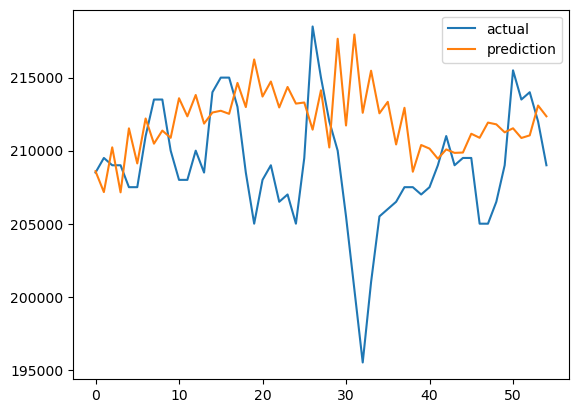

In [45]:
plt.figure()
plt.plot(actual_close_RNN, label = 'actual')
plt.plot(pred_close_RNN, label = 'prediction')
plt.legend()
plt.show()

## 그래프의 형태는 환원하기 전과 환원한 후가 동일함